In [1]:
# Import necessary modules
import sys
sys.path.append('../scripts')

from generate_data import *

# Initialize Spark
spark = create_spark_session()

# Generate and save data
schema = define_schema()
data = generate_sample_data(1000)
df = save_data(spark, data, schema, "../data/raw/support_tickets")

# Display sample data
df.show()

24/12/08 17:23:17 WARN Utils: Your hostname, Josephs-MacBook-Air-67.local resolves to a loopback address: 127.0.0.1; using 10.18.167.2 instead (on interface en0)
24/12/08 17:23:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/08 17:23:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+----------+-----------+---------------+--------+-----------+--------------------+--------------------+------------------+--------------------+
| ticket_id|customer_id| issue_category|priority|     status|       creation_date|     resolution_date|satisfaction_score|         description|
+----------+-----------+---------------+--------+-----------+--------------------+--------------------+------------------+--------------------+
|TICK-00000|   CUST-073|       Security|Critical|In Progress|2024-11-27 04:28:...|                NULL|              NULL|Customer reported...|
|TICK-00001|   CUST-012|       Security|     Low|  Escalated|2024-11-29 23:25:...|                NULL|              NULL|Customer reported...|
|TICK-00002|   CUST-091|     Networking|  Medium|     Closed|2024-11-25 05:50:...|2024-11-28 05:50:...|                 3|Customer reported...|
|TICK-00003|   CUST-084|    Performance|Critical|     Closed|2024-11-14 21:32:...|2024-11-15 10:32:...|                 1|Customer repor

In [2]:
# Generate and save data
schema = define_schema()
data = generate_sample_data(1000)
df = save_data(spark, data, schema, "../data/raw/support_tickets")

# Display a sample of the data
print("Sample of generated tickets:")
df.show(5)

# Show some basic statistics
print("\nDataset Statistics:")
print(f"Total Tickets: {df.count()}")

print("\nDistribution by Category:")
df.groupBy("issue_category").count().show()

print("\nDistribution by Priority:")
df.groupBy("priority").count().show()

print("\nAverage Resolution Time (hours) by Priority:")
df.filter(df.resolution_date.isNotNull()) \
  .selectExpr("priority", "timestampdiff(HOUR, creation_date, resolution_date) as resolution_hours") \
  .groupBy("priority") \
  .avg("resolution_hours") \
  .orderBy("priority") \
  .show()

Sample of generated tickets:
+----------+-----------+---------------+--------+-----------+--------------------+--------------------+------------------+--------------------+
| ticket_id|customer_id| issue_category|priority|     status|       creation_date|     resolution_date|satisfaction_score|         description|
+----------+-----------+---------------+--------+-----------+--------------------+--------------------+------------------+--------------------+
|TICK-00000|   CUST-057|     Networking|     Low|  Escalated|2024-11-25 01:35:...|                NULL|              NULL|Customer reported...|
|TICK-00001|   CUST-005|   Login Issues|     Low|  Escalated|2024-11-12 12:30:...|                NULL|              NULL|Customer reported...|
|TICK-00002|   CUST-083|   Login Issues|    High|     Closed|2024-11-12 13:02:...|2024-11-13 03:02:...|                 1|Customer reported...|
|TICK-00003|   CUST-073|API Integration|     Low|In Progress|2024-11-29 19:27:...|                NULL|    

In [3]:
from etl_pipeline import SupportTicketETL

# Initialize ETL
etl = SupportTicketETL(spark)

# Run pipeline
processed_df = etl.run_pipeline(
    input_path="../data/raw/support_tickets",
    output_path="../data/processed"
)

# Show transformations
print("Sample of processed data:")
processed_df.show()

print("\nSLA Status Distribution:")
processed_df.groupBy("priority", "sla_status").count().orderBy("priority", "sla_status").show()

print("\nCustomer Satisfaction by Category:")
processed_df.groupBy("issue_category").agg({
    "satisfaction_score": "avg",
    "sla_breaches": "sum"
}).show()

Starting ETL pipeline...
Extracting data...
Transforming data...
Loading processed data...
ETL pipeline completed successfully!
Sample of processed data:
+-----------+----------+---------------+--------+-----------+--------------------+--------------------+------------------+--------------------+---------------------+-------------+------------+------------+-------------+------------------+------------+
|customer_id| ticket_id| issue_category|priority|     status|       creation_date|     resolution_date|satisfaction_score|         description|resolution_time_hours|creation_hour|creation_day|  sla_status|total_tickets|  avg_satisfaction|sla_breaches|
+-----------+----------+---------------+--------+-----------+--------------------+--------------------+------------------+--------------------+---------------------+-------------+------------+------------+-------------+------------------+------------+
|   CUST-003|TICK-00875|        Storage|Critical|   Resolved|2024-11-09 08:35:...|2024-11-

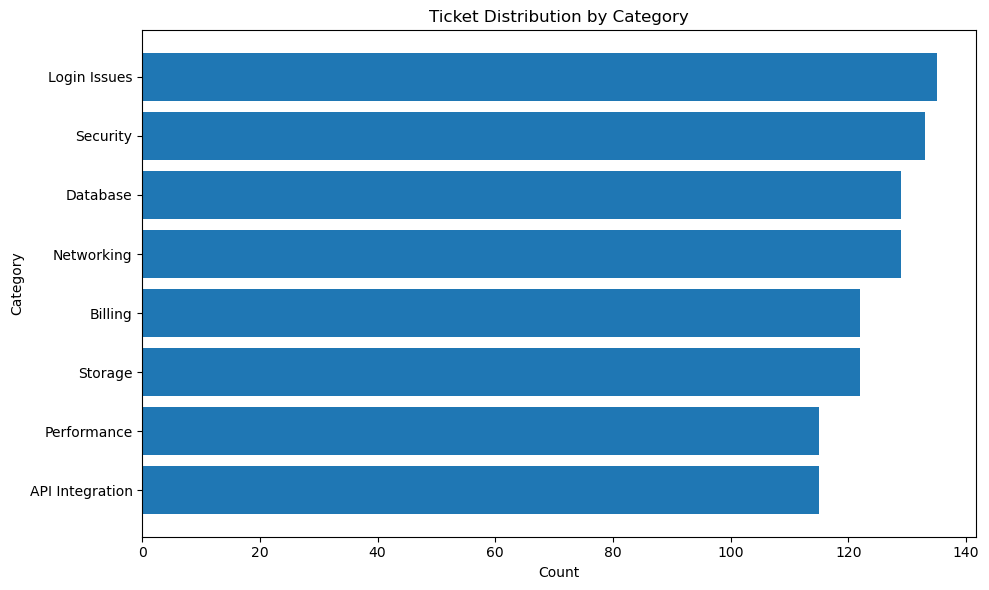

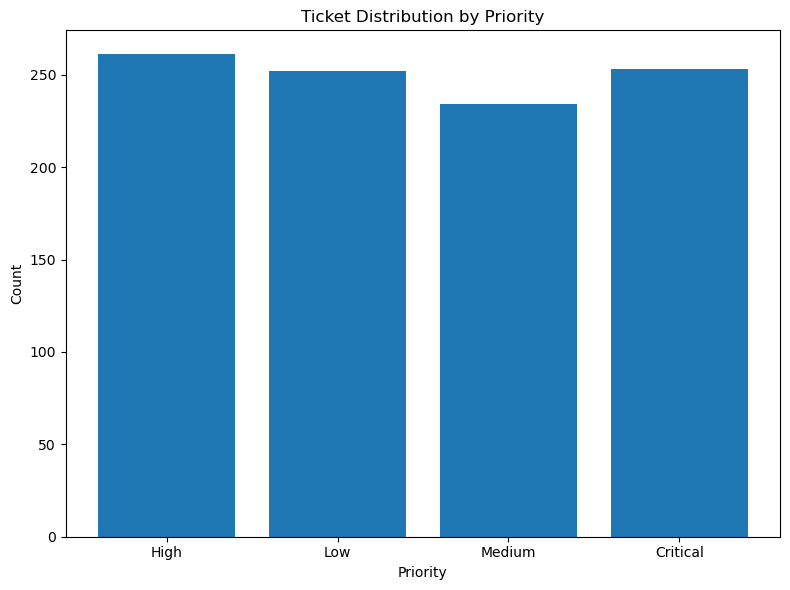

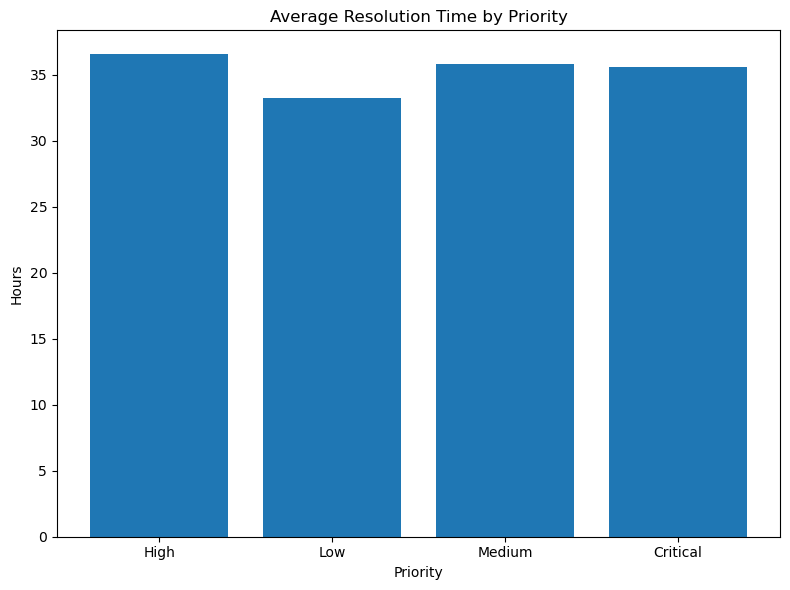

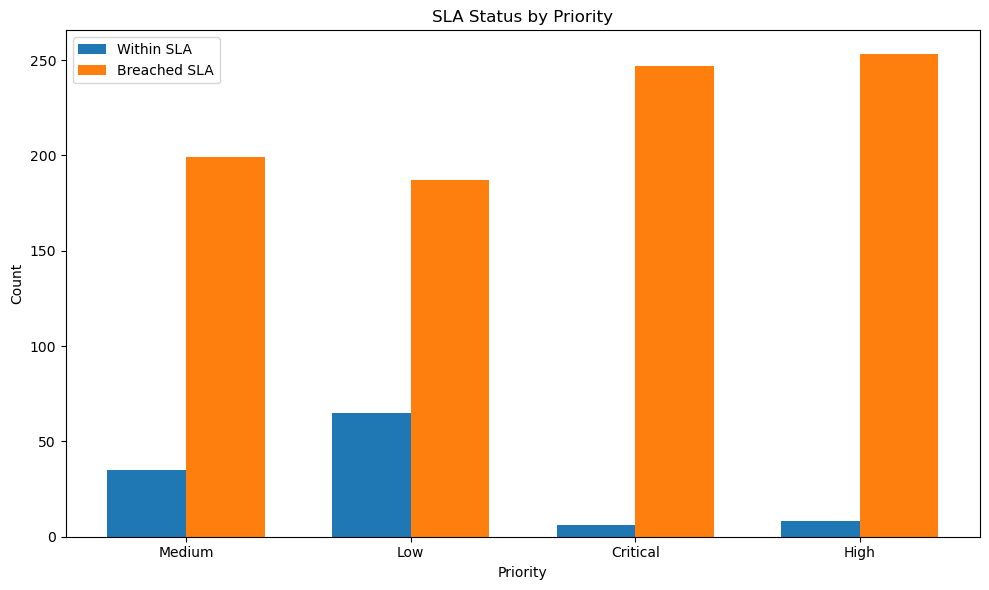

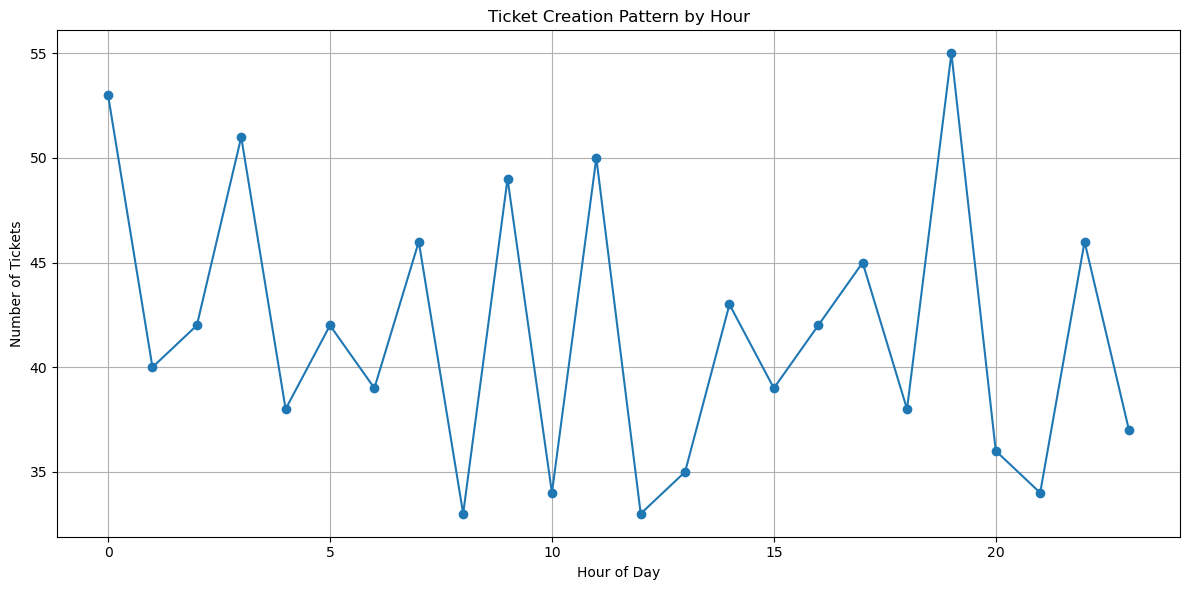

=== Support Ticket Analysis Insights ===

Total Tickets Analyzed: 1000
Average Resolution Time: 35.39 hours
SLA Breach Rate: 88.60%
Average Customer Satisfaction: 3.02/5.0

Top Issue Categories:
+--------------+-----+
|issue_category|count|
+--------------+-----+
|  Login Issues|  135|
|      Security|  133|
|    Networking|  129|
|      Database|  129|
|       Storage|  122|
+--------------+-----+
only showing top 5 rows


SLA Breach Analysis by Priority:
+--------+------------------+-----------------+
|priority|breached_sla_count|      breach_rate|
+--------+------------------+-----------------+
|Critical|               247|97.62845849802372|
|    High|               253|96.93486590038314|
|     Low|               187|74.20634920634922|
|  Medium|               199|85.04273504273505|
+--------+------------------+-----------------+



In [4]:
from support_analysis import SupportAnalyzer

# Initialize analyzer
analyzer = SupportAnalyzer(spark)

# Run analysis
df = analyzer.run_analysis("../data/processed/processed_tickets")